#### <b> 데이터셋 다운로드</b>
* <b>학습 데이터셋</b>
    * 마스크 착용(with mask): 9,000장
    * 마스크 미착용(wihtout mask): 9,000장
* <b>테스트 데이터셋</b>
    * 마스크 착용(with mask): 1,000장
    * 마스크 미착용(wihtout mask): 1,000장


In [1]:
!git clone https://github.com/ndb796/Face-Mask-Classification-20000-Dataset

Cloning into 'Face-Mask-Classification-20000-Dataset'...
remote: Enumerating objects: 20017, done.
remote: Total 20017 (delta 0), reused 0 (delta 0), pack-reused 20017
Receiving objects: 100% (20017/20017), 600.78 MiB | 19.50 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (20001/20001), done.


In [2]:
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

#### <b> 데이터셋 불러오기</b>

* 학습할 이미지 크기: 1 X 64 X 64

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


* 마스크를 착용하지 않은 얼굴을 생성합니다.

### SAGAN 구현을 위한 Self_Attention ###


In [5]:
class Self_Attention(nn.Module) :
    '''Self-Attention layer'''
    
    def __init__(self, in_dim) :
        super(Self_Attention, self).__init__()
        
        # 1x1의 합성곱 층을 활용한 점별 합성곱 준비
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8,
                                   kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8,
                                 kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim,
                                   kernel_size=1)
        
        # Attention Map을 작성할 때 규격화 소프트맥스
        self.softmax = nn.Softmax(dim=-2)
        
        # 원래 입력 x와 Self-Attention Map인 o를 더할 때 계수
        # output = x + gamma * o
        # 처음에는 gamma=0으로 학습시킨다.
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x) :
        
        # 입력 변수
        X = x
        
        # 합성곱한 뒤 크기를 변형시킴. B, C', W, H->B, C', N으로
        proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3]) 
        # 크기 : B, C', N
        proj_query = proj_query.permute(0, 2, 1) # 전치 조작
        proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2] * X.shape[3]) 
        # 크기 : B, C', N
        
        # 곱셈
        S = torch.bmm(proj_query, proj_key) # bmm은 배치별 행렬곱
        
        # 규격화
        attention_map_T = self.softmax(S) # i행 방향의 합을 1로 하는 소프트맥스 함수
        attention_map = attention_map_T.permute(0, 2, 1) # 전치
        
        # Self-Attention Map 계산
        proj_value = self.value_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1)) # Attention Map을 전치하여 곱함
        
        # Self-Attention Map의 텐서 크기를 X로 준비하여 출력
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x + self.gamma * o
        
        return out, attention_map

### 생성자 ###

In [6]:
latent_dim = 100
n_classes = 2

# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self, z_dim=100, image_size=64) :
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(n_classes, n_classes)
        self.layer1 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim+2, image_size*8,
                                                 kernel_size=4, stride=1)),
        nn.BatchNorm2d(image_size*8),
        nn.LeakyReLU(0.2, inplace=True))
        
        self.layer2 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*8,
                                image_size*4, kernel_size=4, stride=2,
                                                 padding=1)),
                                nn.BatchNorm2d(image_size*4),
                                nn.LeakyReLU(0.2, inplace=True))
        
        self.layer3 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*4, image_size*2,
                                kernel_size=4, stride=2, padding=1)),
        
        nn.BatchNorm2d(image_size*2),
        nn.LeakyReLU(0.2, inplace=True))
        
        # Self-Attention 층 추가
        self.self_attention1 = Self_Attention(in_dim=image_size*2)
        
        self.layer4 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*2, image_size,
                                kernel_size=4, stride=2, padding=1)),
        nn.BatchNorm2d(image_size),
        nn.LeakyReLU(0.2, inplace=True))
        
        # Sself-Attention 층 추가
        self.self_attention2 = Self_Attention(in_dim=image_size)
        
        self.last = nn.Sequential(nn.ConvTranspose2d(image_size,
                                1, kernel_size=4, stride=2, padding=1),
                                 nn.Tanh())
        # 주의 ! 흑백 화상이므로 출력 채널은 하나 뿐이다
        
    def forward(self, noise, labels):
        embed = self.label_embed(labels)
        embed = embed.view(-1,n_classes, 1, 1)
        inputs = torch.cat((noise, embed), dim=1)
        out = self.layer1(inputs)
        out = self.layer2(out)
        out = self.layer3(out)        
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2


### 판별자 ###

In [7]:
class Discriminator(nn.Module) :
    
    def __init__(self, z_dim=100, image_size=64) :
        super(Discriminator, self).__init__()
        
        self.label_embed = nn.Embedding(n_classes, 1 * 64 * 64)
        
        self.layer1 = nn.Sequential(
                    #스펙트럴 정규화 추가
                    nn.utils.spectral_norm(nn.Conv2d(2, image_size, kernel_size=4,
                                                   stride=2, padding=1)),
                    nn.LeakyReLU(0.1, inplace=True))
                    # 흑백 화상이므로 출력 채널은 하나뿐이다.
            
        self.layer2 = nn.Sequential(
                    # 스펙트럴 정규화 추가
                    nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, 
                                                    kernel_size=4, stride=2,
                                                    padding=1)),
                    nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
                    # 스펙트럴 정규화 추가
                    nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, 
                                                    kernel_size=4, stride=2,
                                                    padding=1)),
                    nn.LeakyReLU(0.1, inplace=True))
            
        # Self-Attention 층 추가
        self.self_attention1 = Self_Attention(in_dim = image_size * 4)
        
        self.layer4= nn.Sequential(
                    # 스펙트럴 정규화 추가
                    nn.utils.spectral_norm(nn.Conv2d(image_size * 4, image_size * 8,
                                                    kernel_size=4, stride=2, padding=1)),
                    nn.LeakyReLU(0.1, inplace=True))
         
        
        # Self-Attention 층 추가
        self.self_attention2 = Self_Attention(in_dim=image_size*8)
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
            
    
    def forward(self, img, labels) :
        embed = self.label_embed(labels).view((img.size(0), 1, 64, 64))
        inputs = torch.cat((img, embed), 1)
        out = self.layer1(inputs)
        out = self.layer2(out)
        out = self.layer3(out)            
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2

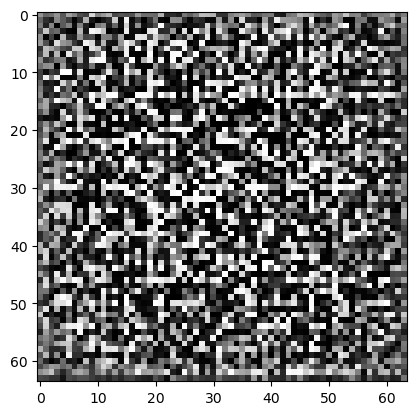

In [8]:
#test printing
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=100, image_size=64)

input_z = torch.randn(1, 100)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

generated_labels = torch.randint(0, n_classes, (1,))
fake_images, attention_map1, attention_map2 = G(input_z, generated_labels)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [9]:
# test printing

D = Discriminator(z_dim=100, image_size=64)

input_z = torch.randn(1, 100)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
generated_labels = torch.randint(0, n_classes, (1,))
fake_images, _, _ = G(input_z, generated_labels)

d_out, attention_map1, attention_map2 = D(fake_images, generated_labels)

print(nn.Sigmoid()(d_out))

tensor([[[[0.4873]]]], grad_fn=<SigmoidBackward0>)


### Loss함수 ###

In [32]:
# SAGAN의 D 손실함수
d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()

# SAGAN의 G 손실함수
g_loss = -d_out_fake.mean()

In [10]:
# SAGAN의 학습 함수 구현

# 모델을 학습시키는 함수 작성
def train_model(G, D, dataloader, num_epochs) :
    
    # GPU 사용 여부 확인
    device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('사용 장치 :', device)
    
    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # 오차함수 정의 -> 적대적 손실의 힌지 버전으로 변경
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # 파라미터 하드코딩
    z_dim = 100
    mini_batch_size=64
    
    # 네트워크를 GPU로
    G.to(device)
    D.to(device)
    
    G.train() # 모델을 훈련 모드로
    D.train() # 모델을 훈련 모드로
    
    # 네트워크가 어느 정도 고정되면 고속화
    torch.backends.cudnn.benchmark = True
    
    # 화상 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # 반복 카운터 설정
    iteration = 1
    logs = []
    
    # 에폭 루프
    for epoch in range(num_epochs) :
        
        # 개시 시간 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0 # 에폭의 손실 합
        epoch_d_loss = 0.0 # 에폭의 손실 합
        
        print('-' * 20)
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 20)
        print(' (train) ')
        
        # 데이터 로더에서 미니배치 씩 꺼내는 루프
        for data in dataloader :
            
            images = data[:][0]
            labels = data[:][1]
            
            # ------------------------
            # 1. discriminator 학습
            # ------------------------
            # 미니 배치 크기가 1이면 배치 정규화에서 오류가 발생하므로 피한다
            if images.size()[0] == 1 :
                continue
                
            # GPU를 사용할 수 있으면 GPU로 데이터를 보낸다
            images= images.to(device)
            labels= labels.to(device)
            
            # 정답 라벨과 가짜 라벨 작성
            # 에폭의 마지막 반복은 미니배치 수가 줄어듦
            mini_batch_size = images.size()[0]
            # label_real = torch.full((mini_batch_size,), 1).to(device)
            # label_fake = torch.full((mini_batch_size,), 0).to(device)    
            
            # 진짜 화상 판정
            d_out_real, _, _ = D(images, labels)
            
            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size , latent_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z, labels)
            d_out_fake, _, _ = D(fake_images, labels)
            
            # 오차 계산 --> 적대적 손실의 힌지 버전으로 변경
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 오차 d_out_real이 1 이상에서 오차 0이 된다. d_out_real > 1에서
            # 1.0 - d_out_real이 음수이면 ReLU 로 0으로 한다.
            
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 오차 d_out_fake가 -1 이하이면 오차 0이 된다. d_out_fake < -1에서
            # 1.0 + dout_real이 음수이면 ReLU로 0으로 한다.
            
            d_loss = d_loss_real + d_loss_fake
            
            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            # ------------------------
            # 2. Generator 학습
            # ------------------------
            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z, labels)
            d_out_fake, _, _ = D(fake_images, labels)
            
            # 오차 계산 --> 적대적 손실의 힌지 버전으로 변경
            #g_loss = criterion(d_out_fake.view(-1), label_real)
            g_loss = -d_out_fake.mean()
            
            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # ------------------------
            # 3. 기록
            # ------------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # 에폭의 phase 별 손실과 정답률
        t_epoch_finish = time.time()
        print('-' * 20)
        print(f'epoch {epoch} || epoch_D_Loss : {epoch_d_loss/batch_size:.4f} \ || Epoch_G_Loss : {epoch_g_loss/batch_size:.4f}')
        print(f'timer: {t_epoch_finish  - t_epoch_start:.4f}')
        t_epoch_start = time.time()
              
    return G, D

In [11]:
# 네트워크 초기화
def weights_init(m) :
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        # Conv2d와 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 :
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data ,1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    
# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (label_embed): Embedding(2, 4096)
  (layer1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (self_attention1): Self_Attention(
    (query_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-2)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (self_attention2): Self_Attention(
    (q

In [44]:
# 학습 및 검증 실행
num_epochs = 10
G_update, D_update = train_model(G_update, D_update, dataloader=train_dataloader, num_epochs=num_epochs)

사용 장치 : cuda:0
--------------------
Epoch 0/10
--------------------
 (train) 
--------------------
epoch 0 || epoch_D_Loss : 1.0576 \ || Epoch_G_Loss : 9.5123
timer: 35.0391
--------------------
Epoch 1/10
--------------------
 (train) 
--------------------
epoch 1 || epoch_D_Loss : 1.0599 \ || Epoch_G_Loss : 9.5402
timer: 34.1593
--------------------
Epoch 2/10
--------------------
 (train) 
--------------------
epoch 2 || epoch_D_Loss : 1.0104 \ || Epoch_G_Loss : 9.7315
timer: 33.8522
--------------------
Epoch 3/10
--------------------
 (train) 
--------------------
epoch 3 || epoch_D_Loss : 0.9738 \ || Epoch_G_Loss : 9.7933
timer: 33.9249
--------------------
Epoch 4/10
--------------------
 (train) 
--------------------
epoch 4 || epoch_D_Loss : 0.9772 \ || Epoch_G_Loss : 9.8726
timer: 34.1256
--------------------
Epoch 5/10
--------------------
 (train) 
--------------------
epoch 5 || epoch_D_Loss : 0.9537 \ || Epoch_G_Loss : 9.9232
timer: 34.0554
--------------------
Epoch 6/10

torch.Size([1])


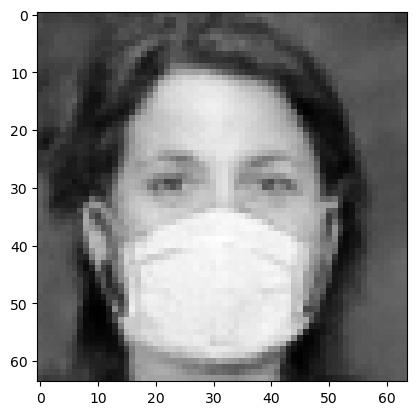

In [45]:
#test printing
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_z = torch.randn(1, 100).to(device)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

generated_labels = torch.randint(0, n_classes, (1,)).to(device)
print(generated_labels.shape)
fake_images, attention_map1, attention_map2 = G_update(input_z, generated_labels)

img_transformed = fake_images[0][0].cpu().detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [46]:
!mkdir -p ./results/simple/with_mask
!mkdir -p ./results/simple/without_mask

from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    input_z = torch.randn(100, 100).to(device)
    input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

    generated_labels = torch.zeros(100,).to(device)
    generated_labels = generated_labels.int()
    # 이미지 생성
    generated_imgs, _, _ = G_update(input_z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/simple/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    input_z = torch.randn(100, 100).to(device)
    input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

    generated_labels = torch.ones(100,).to(device)
    generated_labels = generated_labels.int()
    generated_imgs, _, _ = G_update(input_z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/simple/without_mask/{i * 100 + j}.png', normalize=True)

NameError: name 'am1' is not defined

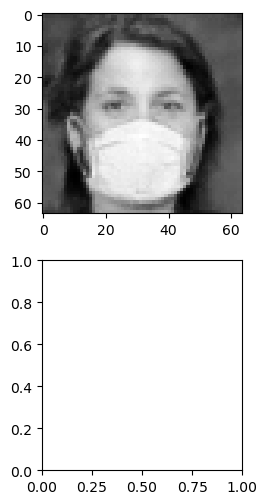

In [47]:
# Attention Map 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5) :
    
    # 하단에 생성한 화상 데이터 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    
    # 하단에 Attention Map 1 화상 중앙의 픽셀 데이터 표시
    plt.subplot(2, 5, 5+i+1) 
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7] # 중앙에 주목
    plt.imshow(am.cpu().detach().numpy(), 'Reds')

In [38]:
!git clone https://github.com/hukkelas/pytorch-frechet-inception-distance

Cloning into 'pytorch-frechet-inception-distance'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Receiving objects: 100% (22/22), 12.21 KiB | 6.11 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [48]:
# 평가 수행
!python pytorch-frechet-inception-distance/fid.py --path1 ./results/simple/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

Looking for images in ./results/simple/without_mask/*.png
Looking for images in ./results/simple/without_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.jpg
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
150.2607349089571


In [49]:
# 평가 수행
!python pytorch-frechet-inception-distance/fid.py --path1 ./results/simple/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/simple/with_mask/*.png
Looking for images in ./results/simple/with_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.jpg
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
88.62199979087016


In [ ]:
# ./results/custom/ 폴더의 모든 파일을 results.zip라는 이름으로 압축
!zip ./results.zip -r ./results/custom/*